In [1]:
import netCDF4 as nc
import scipy.io as sio
import os,sys,fnmatch,time
from scipy import interpolate
import numpy as np
import numpy.ma as ma
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import cmocean as cmo

from salishsea_tools.nc_tools import scDataset
from salishsea_tools import geo_tools

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_plot

sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

(cmapmc, norm) = functions_plot.Colormap()
from matplotlib.colors import ListedColormap
cmapmc_r = ListedColormap(cmapmc.colors[::-1])
from matplotlib.colors import LinearSegmentedColormap
colour_list = ["#c8274c","#f25546","#F06543","#e96e33",
               "#f0b038","#FFE74C","#69b944","#72b286",
               "#69b0bc","#619ee4","#4b5bbb"][::-1]
cmapIAM = LinearSegmentedColormap.from_list('mycmap', colour_list, N=500, gamma=1)

In [2]:
def plot_map(fig, ax, x, y, z, cmapmc):
    if cmapmc == None:
        pass
    else:
        p = ax.pcolorfast(x, y, z, cmap=cmapmc, vmin=-1600, vmax=1000)
    CS = ax.contour(x, y, z, levels = np.arange(-500, 0, 20), colors='k', linestyle='-', alpha=0.5)
    for line in CS.collections:
        if line.get_linestyle() == [(None, None)]:
            print("Solid Line")
        else:
            line.set_linestyle([(None, None)])
            line.set_color('k')
    ax.clabel(CS, fmt='%1.1f')
    n=4
    ax.legend(loc=2, fontsize=20)
    ax.set_xlim([-141, -136])
    ax.set_ylim([69.5, 70.5])
    w=1/math.cos(math.radians(70.0))
    ax.set_aspect(w)
    ax.set_ylabel('latitude [$^o$]', fontsize=20)
    ax.set_xlabel('longitude [$^o$]', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=15)
    fig.tight_layout()
    return fig, ax

In [3]:
data = sio.loadmat('./MackenzieTransects.mat')

struct_north = data['stn']
struct_south = data['sts']

dtype_north = struct_north.dtype
dtype_south = struct_south.dtype

data_north = {n: struct_north[n][0, 0] for n in dtype_north.names}
data_south = {n: struct_south[n][0, 0] for n in dtype_south.names}

In [4]:
dist_s = data_south['dist'][0,:]
lat_s = data_south['latx'][0,:]
lon_s = data_south['lonx'][0,:]
temp_s = ma.masked_invalid(data_south['temp'])
salt_s = ma.masked_invalid(data_south['sal'])
dep_s = data_south['z'][:,0]

In [5]:
dist_n = data_north['dist'][0,:]
lat_n = data_north['latx'][0,:]
lon_n = data_north['lonx'][0,:]
temp_n = ma.masked_invalid(data_north['temp'])
salt_n = ma.masked_invalid(data_north['sal'])
dep_n = data_north['z'][:,0]

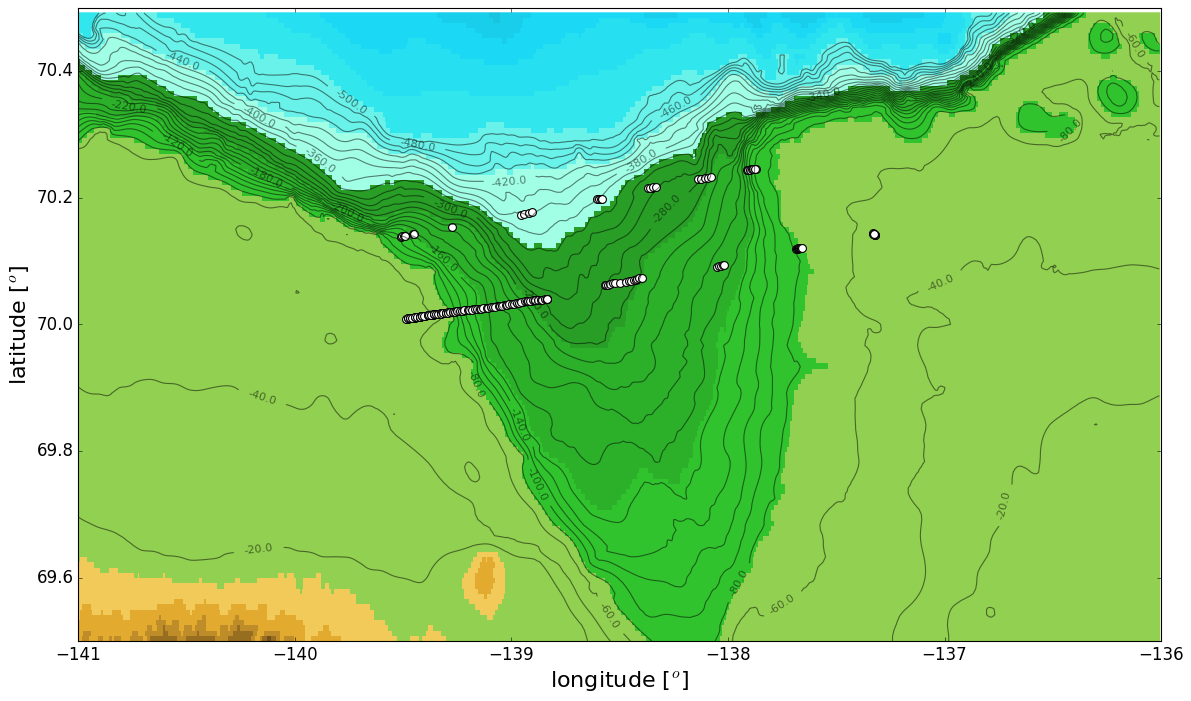

In [6]:
x, y, z = functions_plot.def_regionG(xl=-141, xr=-136, yb=69.5, yt=70.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
fig, ax = plot_map(fig, ax, x, y, z, cmapmc)
ax.scatter(lon_s, lat_s, c='w', s=50, edgecolors='k')
ax.scatter(lon_n, lat_n, c='w', s=50, edgecolors='k')

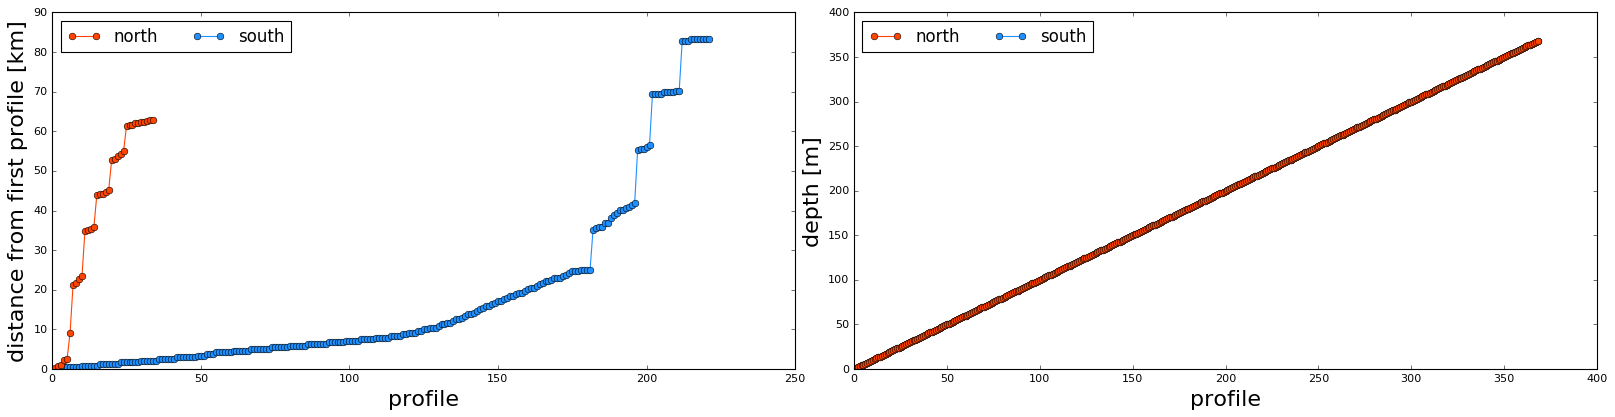

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.tight_layout(w_pad=2.5)
ttls = ['distance from first profile [km]', 'depth [m]']
for ax, plot_s, plot_n, ttl in zip(axes.flatten(), [dist_s, dep_s], [dist_n, dep_n], ttls):
    ax.plot(plot_n, marker='o', c='orangered', zorder=2, label='north')
    ax.plot(plot_s, marker='o', c='dodgerblue', zorder=1, label='south')
    ax.legend(fontsize=15, loc=2, ncol=2)
    ax.set_xlabel('profile', fontsize=20)
    ax.set_ylabel(ttl, fontsize=20)

In [8]:
def plot_crosscanyon_panels(fig, ax, dist, dep, var, num, vmin, vmax, var_name, transect_name):
    cmap = plt.get_cmap(cmapIAM)
    cmap.set_bad('silver')
    
    if num == None:
        p = ax.pcolormesh(dist, dep, var, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([dist.min(), dist.max()])
        ttl_add = ''
    else:
        f = interpolate.interp1d(dist, var)
        dist_new = np.linspace(dist[0], dist[-1], num=num)
        var_new = f(dist_new)
        var_new = ma.masked_invalid(var_new)
        p = ax.pcolormesh(dist_new, dep, var_new, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlim([dist_new.min(), dist_new.max()])
        ttl_add = ' (interpolated)'
        
    ax.set_ylim([np.nanmax(dep), np.nanmin(dep)])
    ax.set_xlabel('distance', fontsize=20)
    ax.set_ylabel('depth [m]', fontsize=20)
    fig.colorbar(p, ax=ax)
    ax.set_title(transect_name+' '+var_name + ttl_add, fontsize=20)
    return ax

In [9]:
def plot_crosscanyon_story(dist, dep, temp, salt, num, transect_name, x, y, z, lon, lat):
    fig = plt.figure(figsize=(20, 14))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1))

    fig, ax0 = plot_map(fig, ax0, x, y, z, cmapmc)
    ax0.scatter(lon, lat, c='w', s=50, edgecolors='k')
    ax0.set_title(transect_name+' stations', fontsize=20)
    
    ax1 = plot_crosscanyon_panels(fig, ax1, dist, dep, temp, num, -1.5, 4, 'temperature', transect_name)
    ax2 = plot_crosscanyon_panels(fig, ax2, dist, dep, salt, num, 29, 34, 'salinity', transect_name) 
               
    fig.tight_layout(w_pad=0.2)
    return fig

# Southern Transect

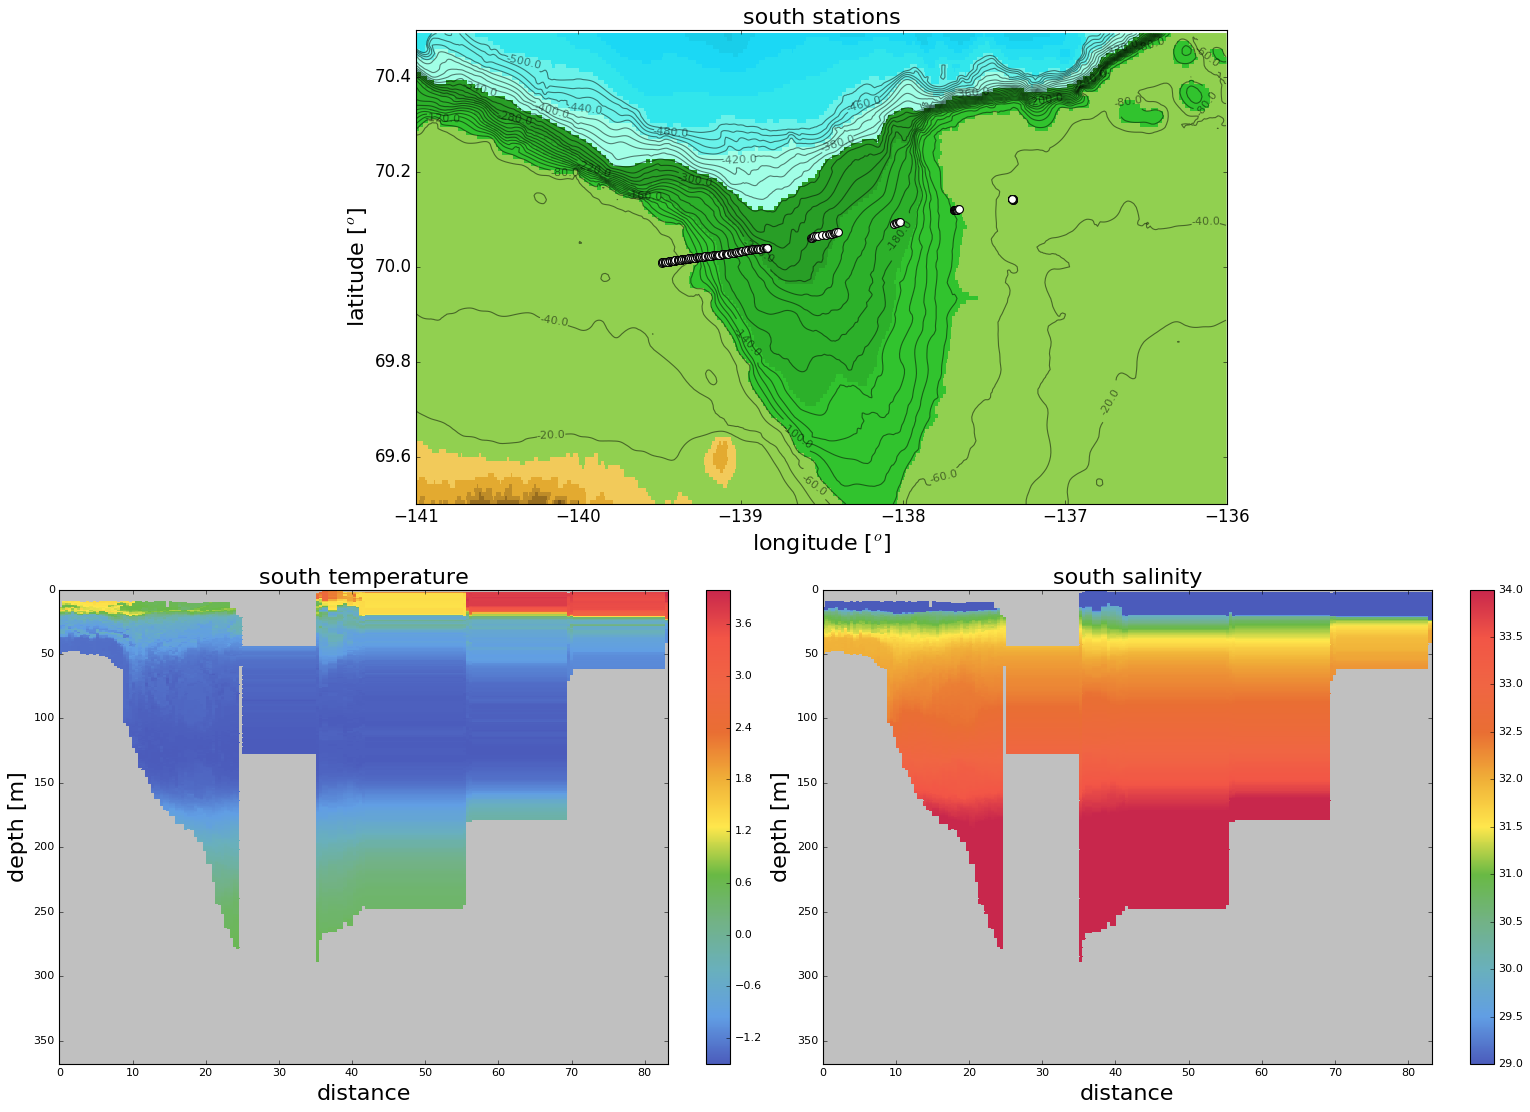

In [10]:
fig = plot_crosscanyon_story(dist_s, dep_s, temp_s, salt_s, None, 'south', x, y, z, lon_s, lat_s)

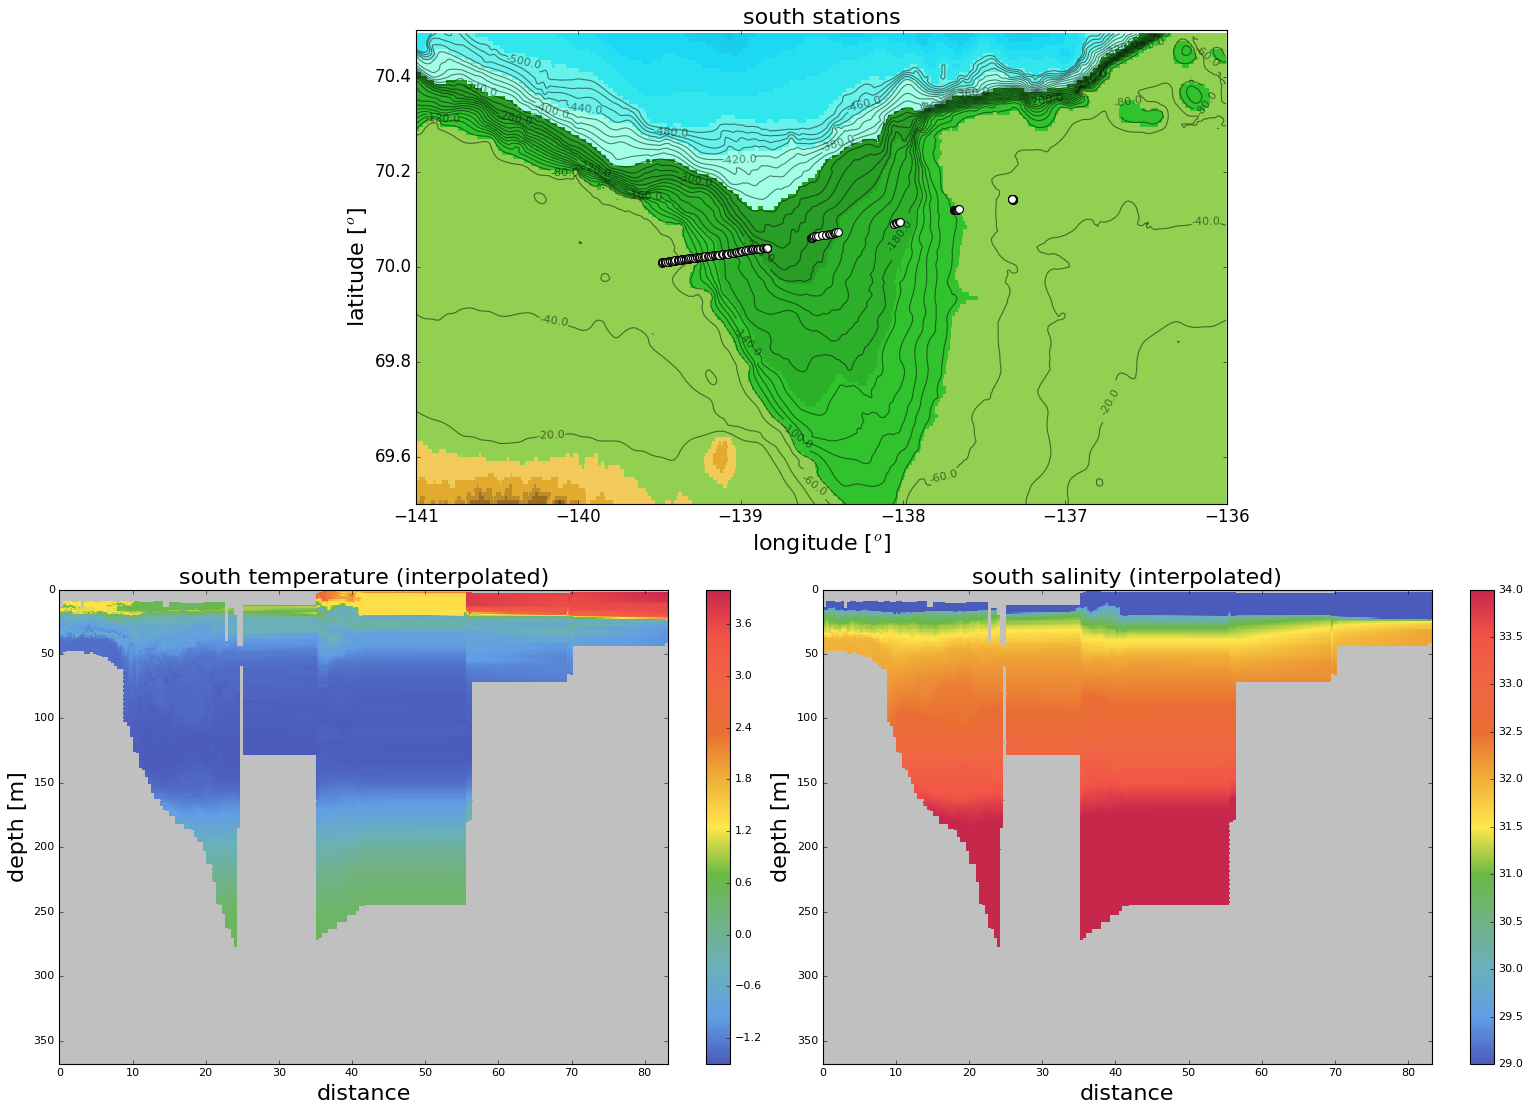

In [11]:
fig = plot_crosscanyon_story(dist_s, dep_s, temp_s, salt_s, 1000, 'south', x, y, z, lon_s, lat_s)

# Northern Transect

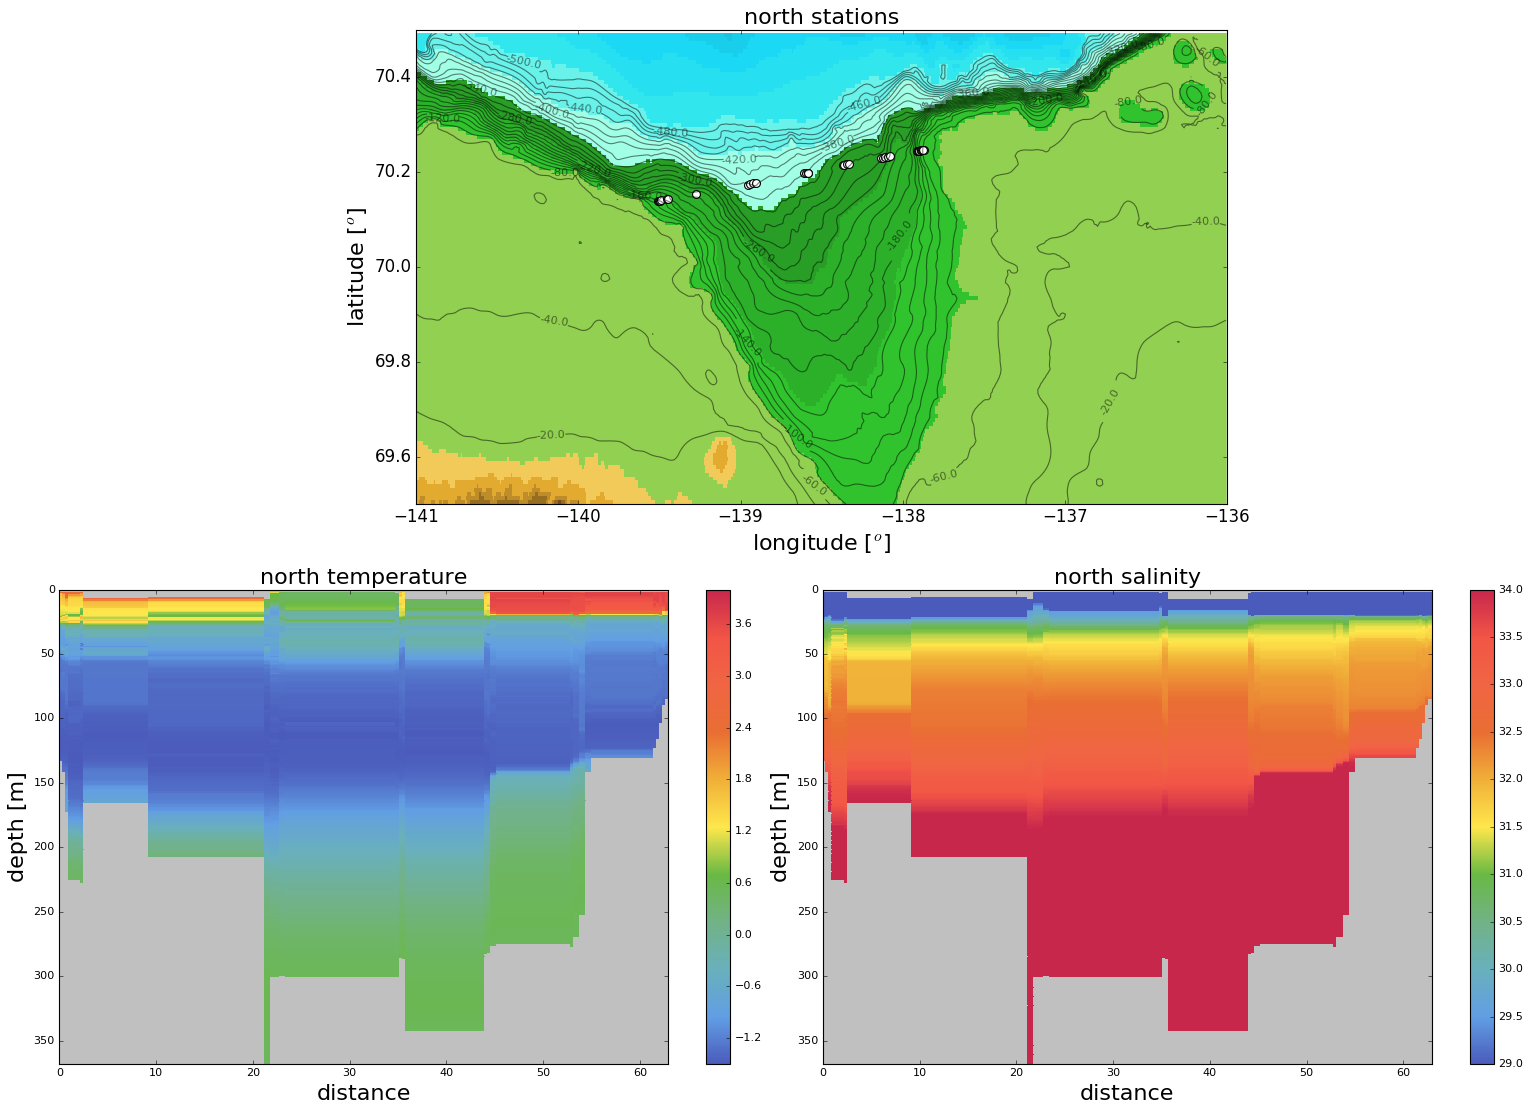

In [12]:
fig = plot_crosscanyon_story(dist_n, dep_n, temp_n, salt_n, None, 'north', x, y, z, lon_n, lat_n)

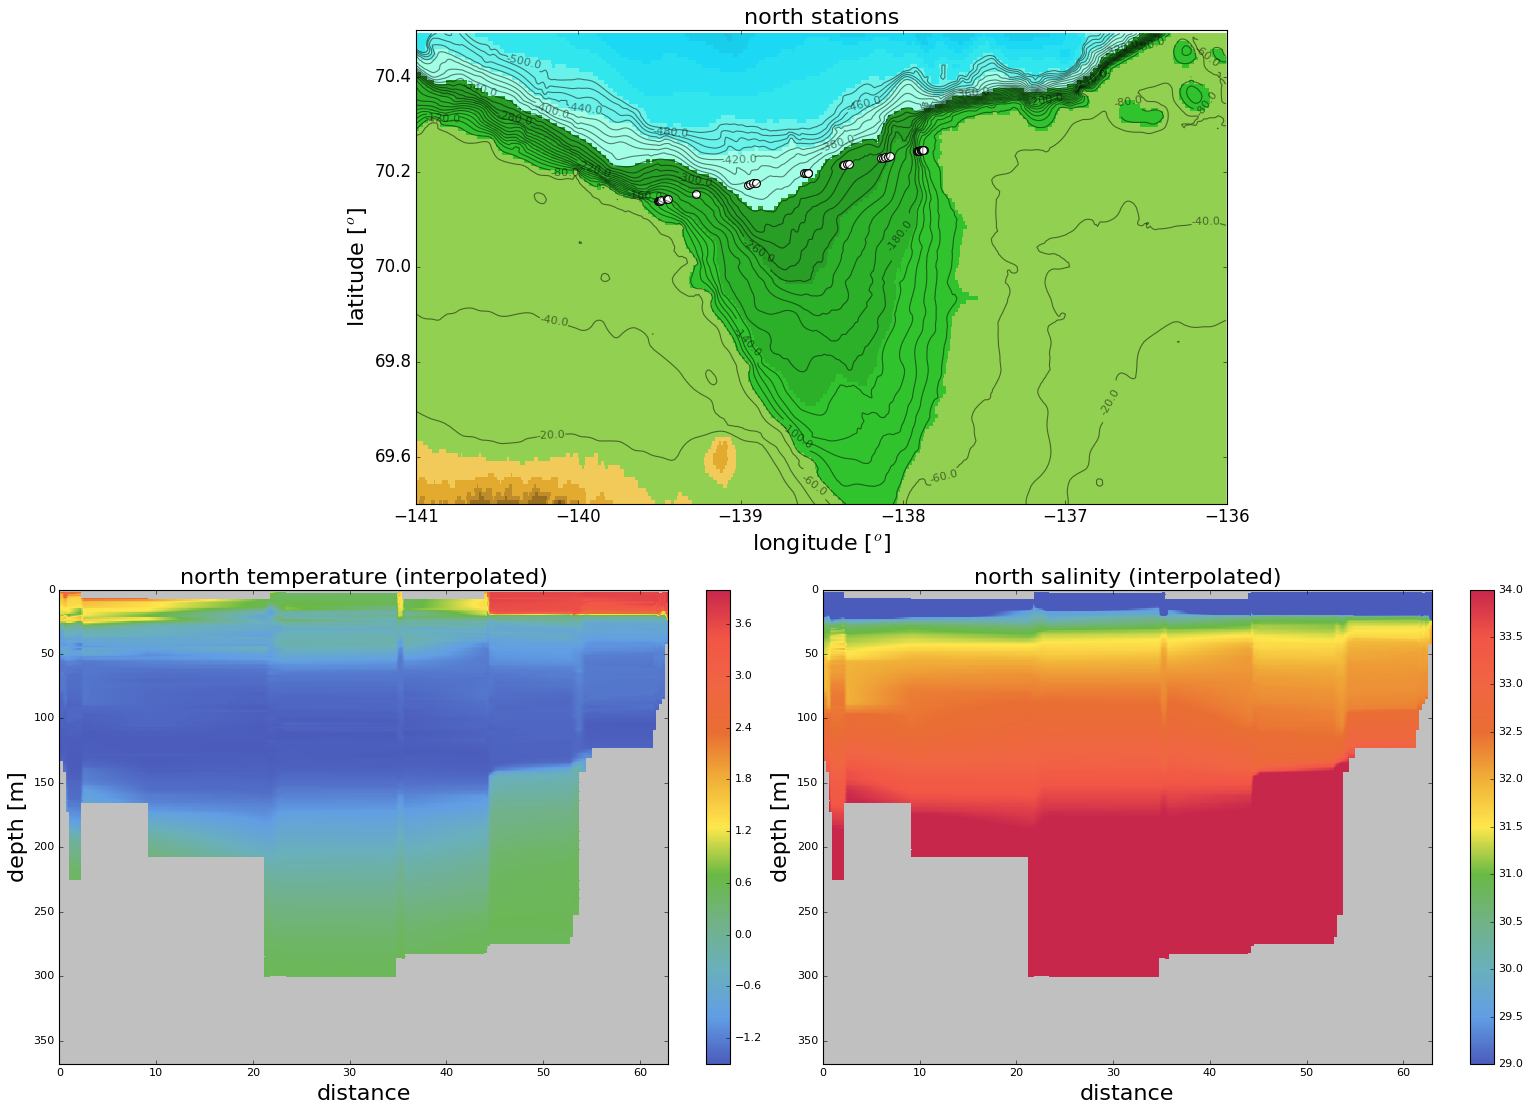

In [13]:
fig = plot_crosscanyon_story(dist_n, dep_n, temp_n, salt_n, 1000, 'north', x, y, z, lon_n, lat_n)

# Depth mean at profile locations

Model depth levels:

     deptht = 4.375, 13.125, 21.875, 30.625, 39.375, 48.125, 56.875, 65.625, 
        74.375, 83.125, 91.875, 100.625, 109.375, 118.125, 126.875, 135.625, 
        144.375, 153.125, 161.875, 170.625, 179.375, 188.125, 196.875, 205.625, 
        214.375, 223.125, 231.875, 240.625, 249.375, 258.125, 266.875, 275.625, 
        284.375, 293.125, 301.875, 310.625, 319.375, 328.125, 336.875, 345.625, 
        354.375, 363.125, 371.875, 380.625, 389.375, 398.125, 406.875, 415.625, 
        424.375, 433.125, 441.875, 450.625, 459.375, 468.125, 476.875, 485.6253, 
        494.3771, 503.1404, 511.9886, 521.4466, 534.6722, 560.3319, 598.4258, 
        640.2872, 682.7585, 725.3146, 767.8822, 810.4514, 853.0208, 895.5903, 
        938.1597, 980.7292, 1023.299, 1065.868, 1108.438, 1151.007, 1193.576, 
        1236.146, 1278.715, 1321.285

In [23]:
def scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n, 
                temp_s, temp_n, salt_s, salt_n, dep1, dep2, var_name):
    
    if var_name == 'temperature':
        vmin_panels, vmax_panels = -1.5, 4
        var_n, var_s = temp_n, temp_s
    elif var_name == 'salinity':
        vmin_panels, vmax_panels = 29, 34
        var_n, var_s = salt_n, salt_s
        
    plot_s = np.mean(var_s[dep1:dep2], axis=0)
    plot_n = np.mean(var_n[dep1:dep2], axis=0)
    
    vmin = min(np.min(plot_s), np.min(plot_n))
    vmax = max(np.max(plot_s), np.max(plot_n))
    
    fig = plt.figure(figsize=(20, 14))
    ax0 = plt.subplot2grid((3, 2), (0, 0))
    ax1 = plt.subplot2grid((3, 2), (0, 1))
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2, rowspan=2)
    
    ax0 = plot_crosscanyon_panels(fig, ax0, dist_n, dep_n, var_n, 1000, vmin_panels, vmax_panels, var_name, 'north')
    ax1 = plot_crosscanyon_panels(fig, ax1, dist_s, dep_s, var_s, 1000, vmin_panels, vmax_panels, var_name, 'south')
    
    ax0.axhline(dep1, c='k', lw=3); ax0.axhline(dep2, c='k', lw=3)
    ax1.axhline(dep1, c='k', lw=3); ax1.axhline(dep2, c='k', lw=3)

    fig, ax2 = plot_map(fig, ax2, x, y, z, None)
    cmap = cmo.cm.matter
    ax2.scatter(lon_s, lat_s, c=plot_s, s=300, edgecolors='k', cmap=cmap, vmin=vmin, vmax=vmax)
    p = ax2.scatter(lon_n, lat_n, c=plot_n, s=300, edgecolors='k', cmap=cmap, vmin=vmin, vmax=vmax)
    
    fig.colorbar(p, ax=ax2, fraction=0.02, pad=0.05)
    ax2.set_xlim([-140, -137.5])
    ax2.set_ylim([69.9, 70.3])
    ax2.set_title(var_name + ' (average for depths ' + str(dep1) + '-' + str(dep2) + ')', fontsize=20)
    
    fig.tight_layout(w_pad=0.2)
    return fig

### 1. Surface

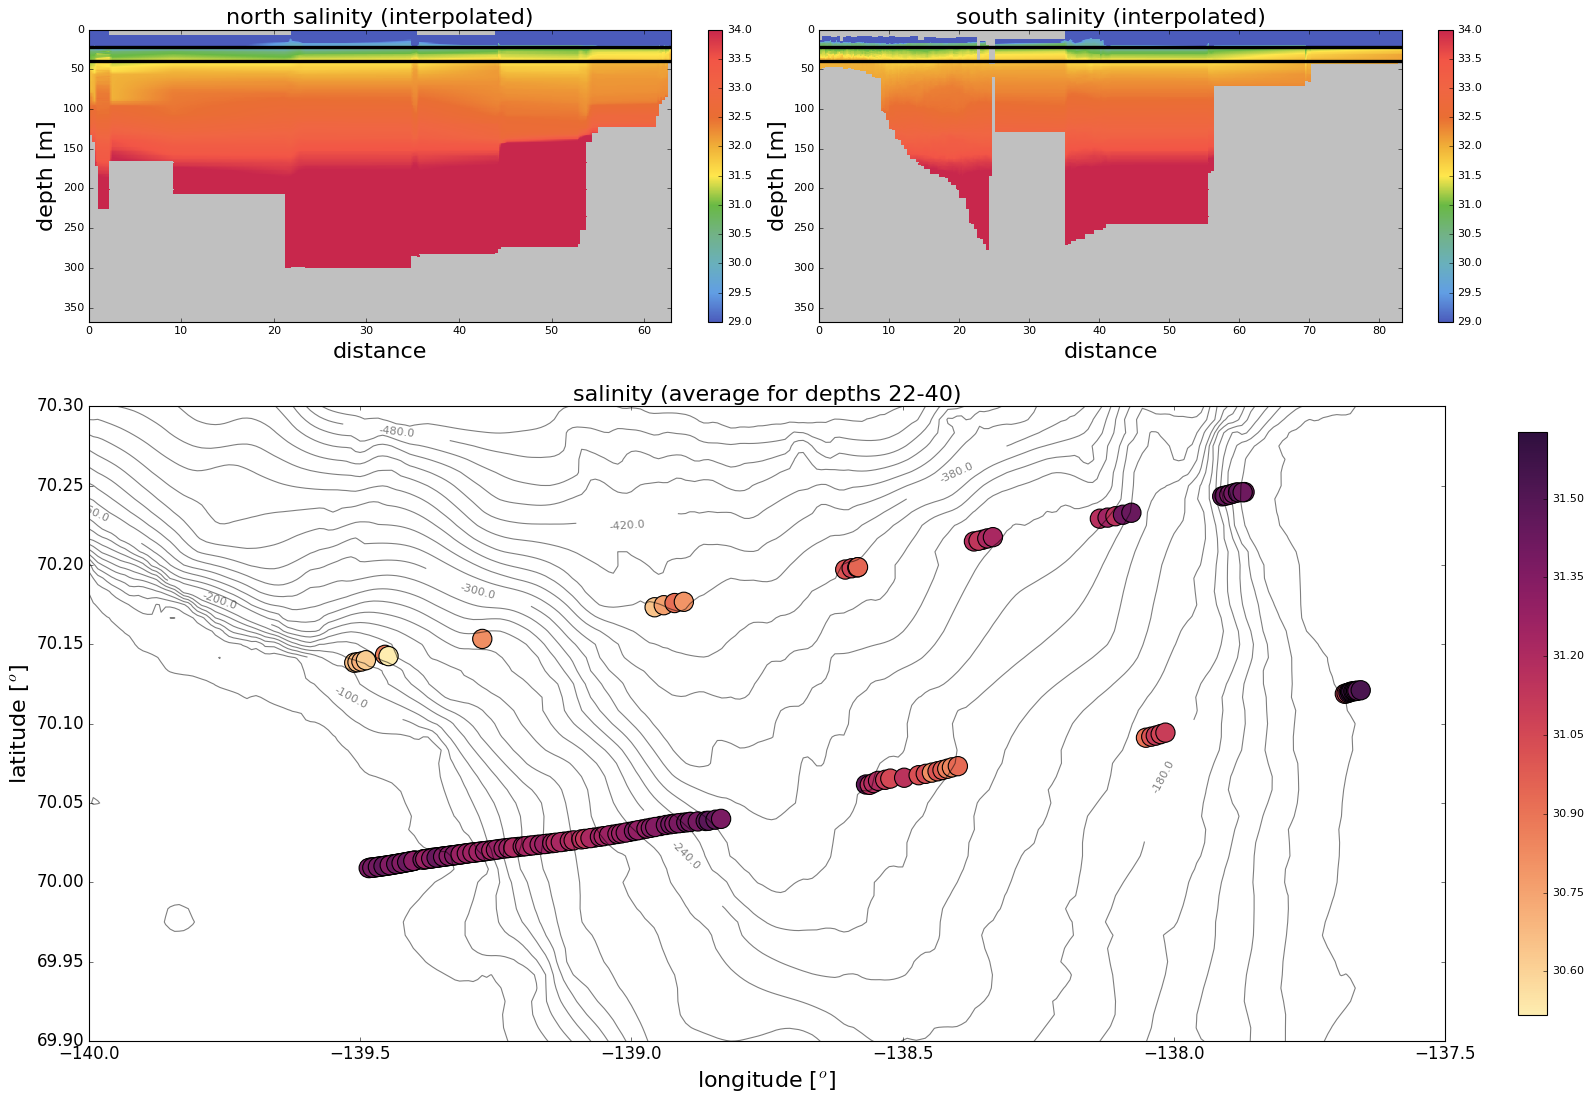

In [30]:
fig = scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n,
                  temp_s, temp_n, salt_s, salt_n, 22, 40, 'salinity')

### 2. Shelf break depth

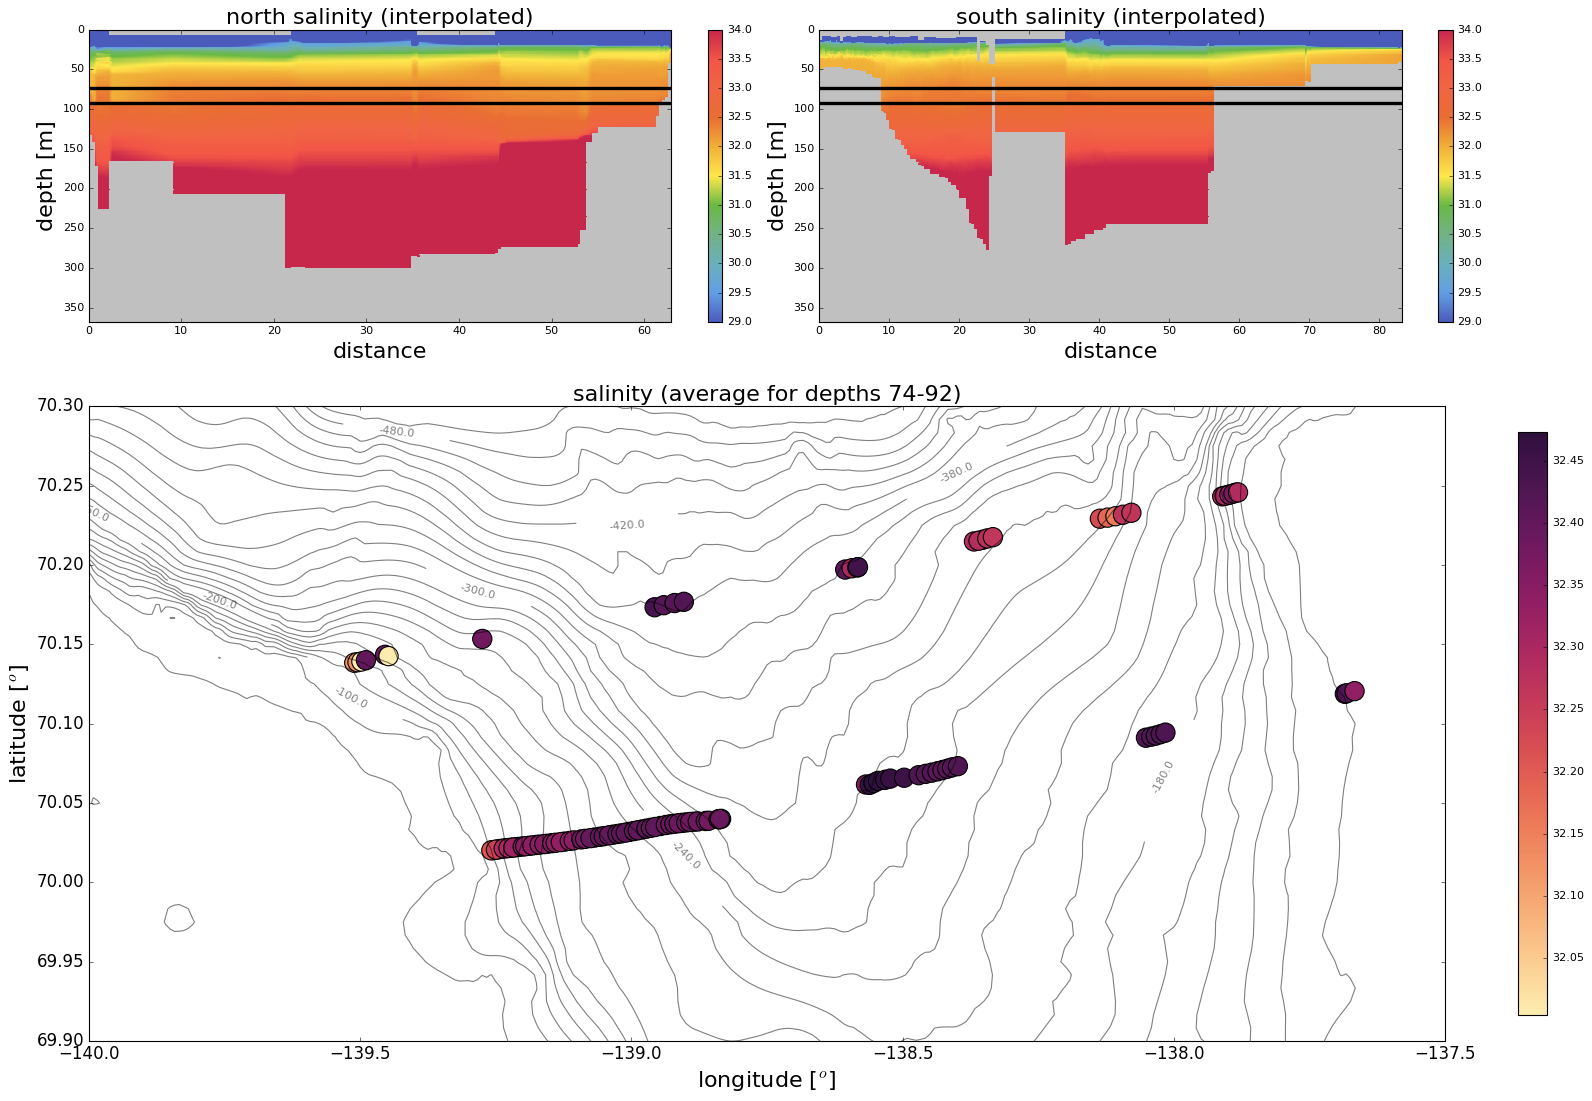

In [25]:
fig = scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n, 
                  temp_s, temp_n, salt_s, salt_n, 74, 92, 'salinity')

### 3. Upwelling on east side of northern section

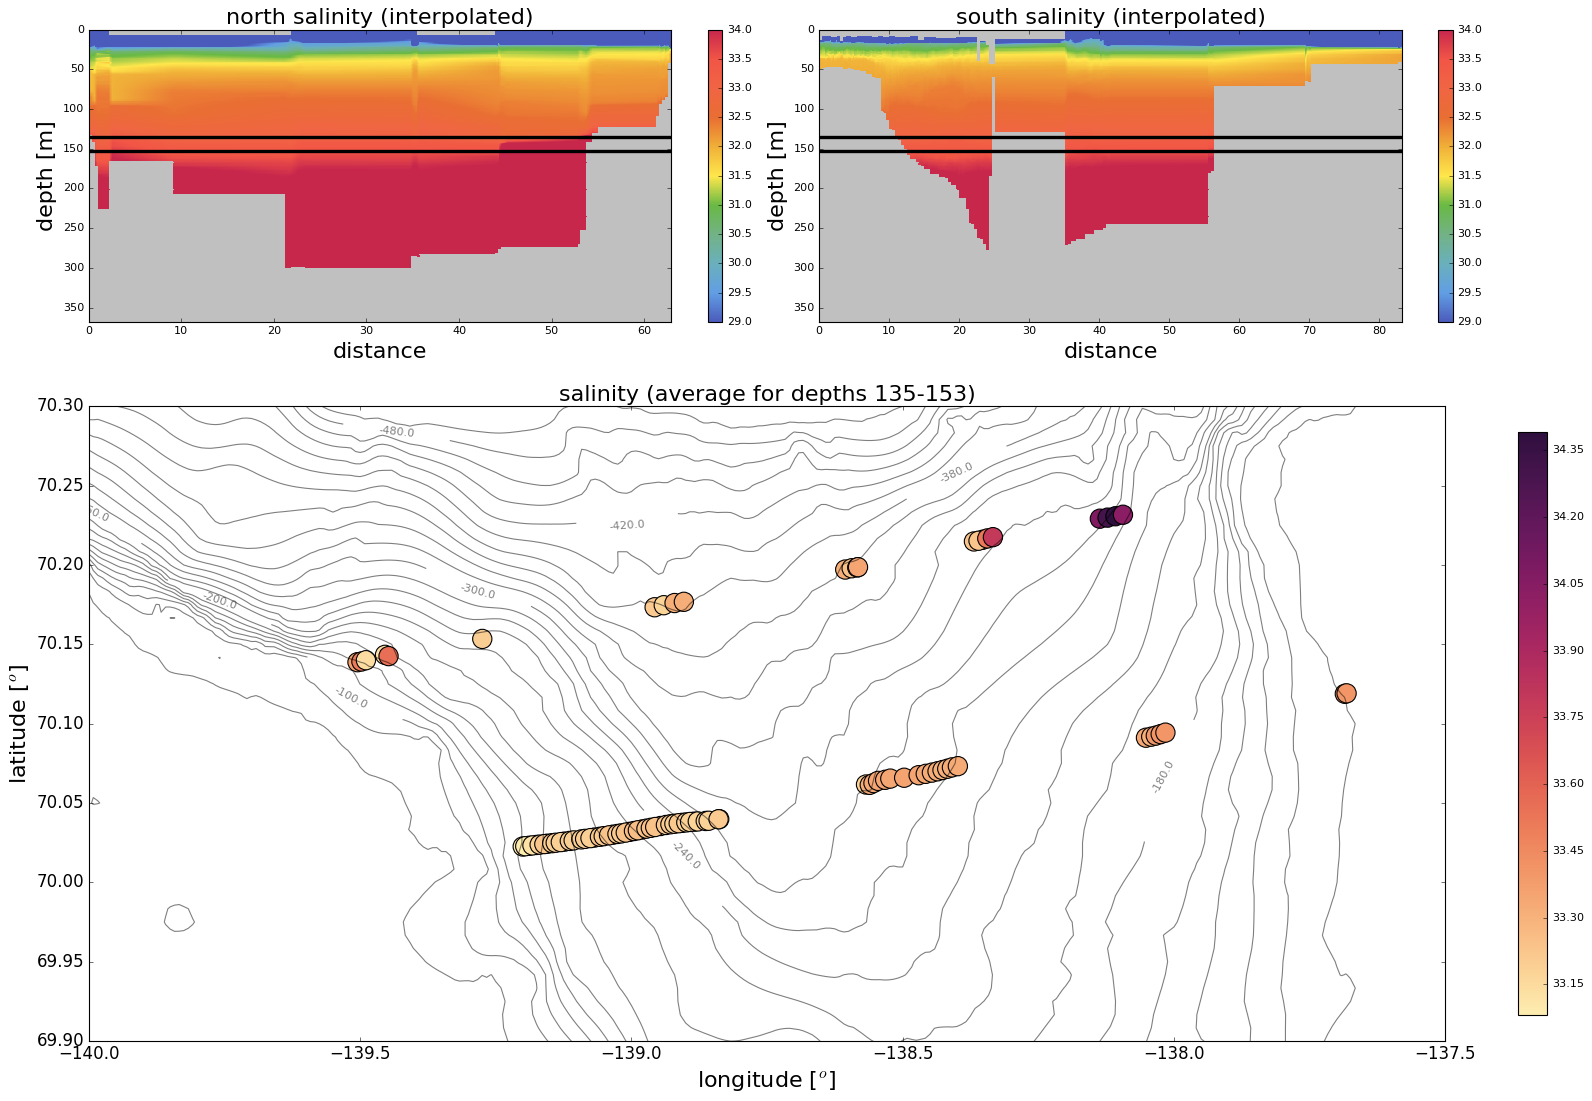

In [26]:
fig = scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n, 
                  temp_s, temp_n, salt_s, salt_n, 135, 153, 'salinity')

### 4. Upwelling on east side of southern section

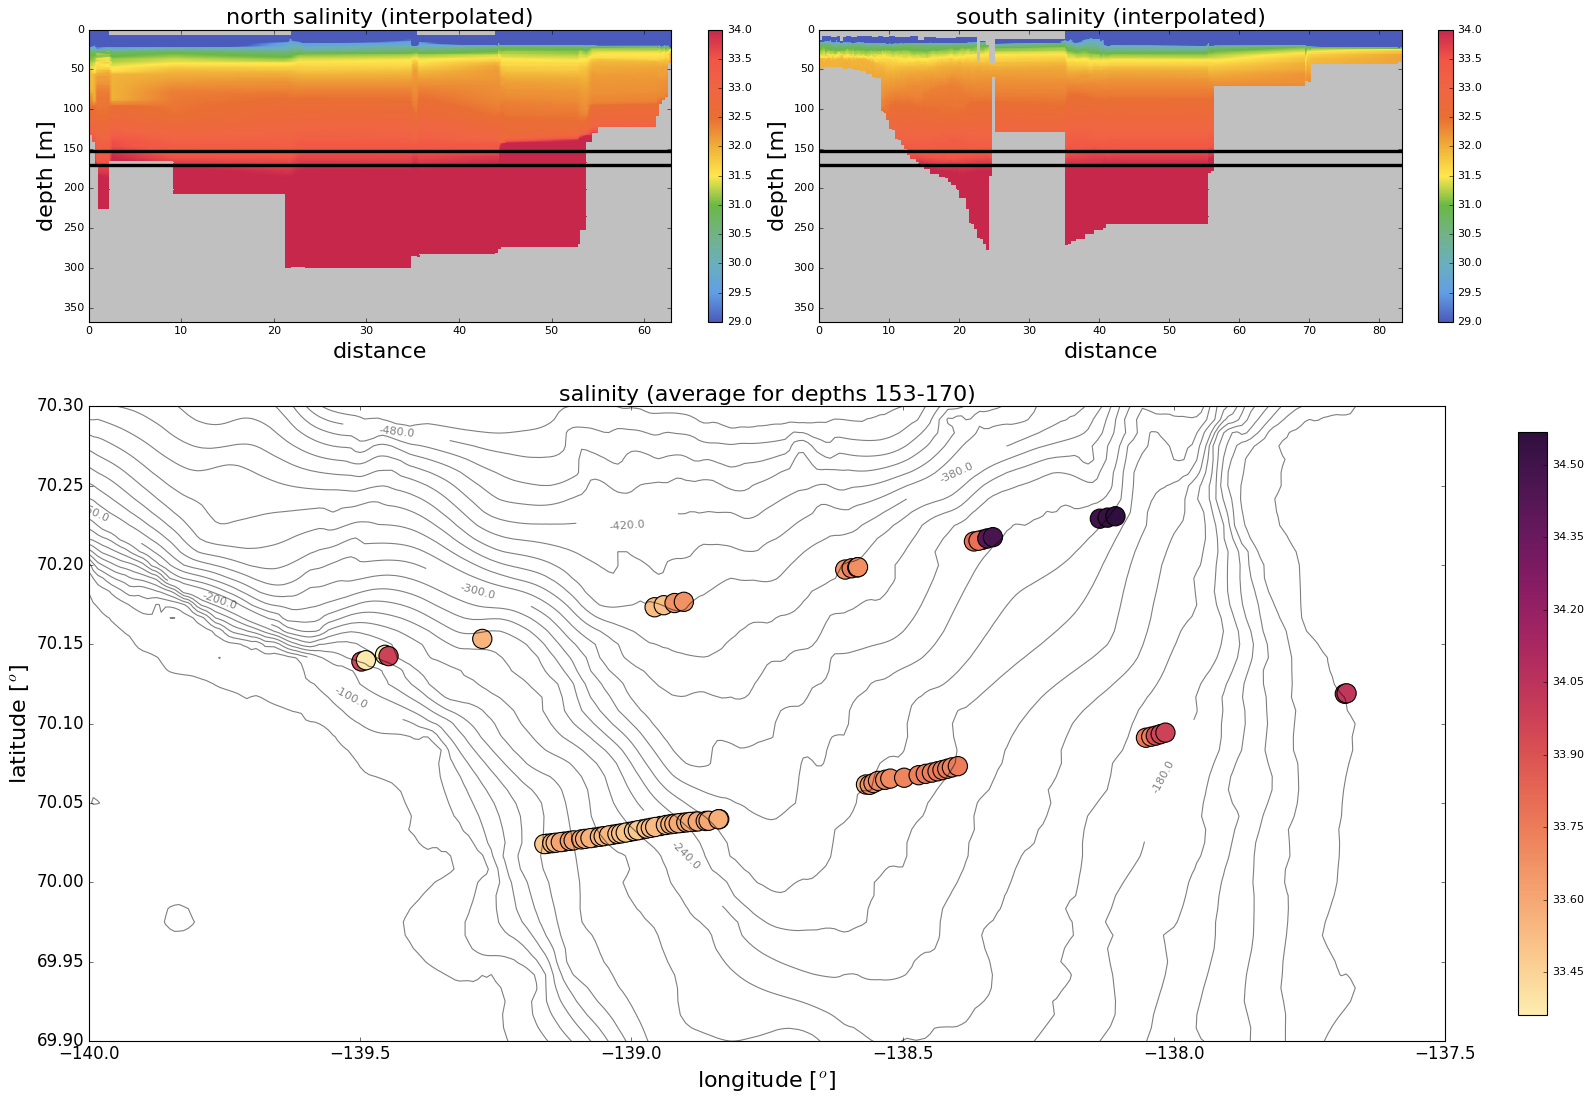

In [27]:
fig = scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n, 
                  temp_s, temp_n, salt_s, salt_n, 153, 170, 'salinity')

### 5. Deeper in canyon

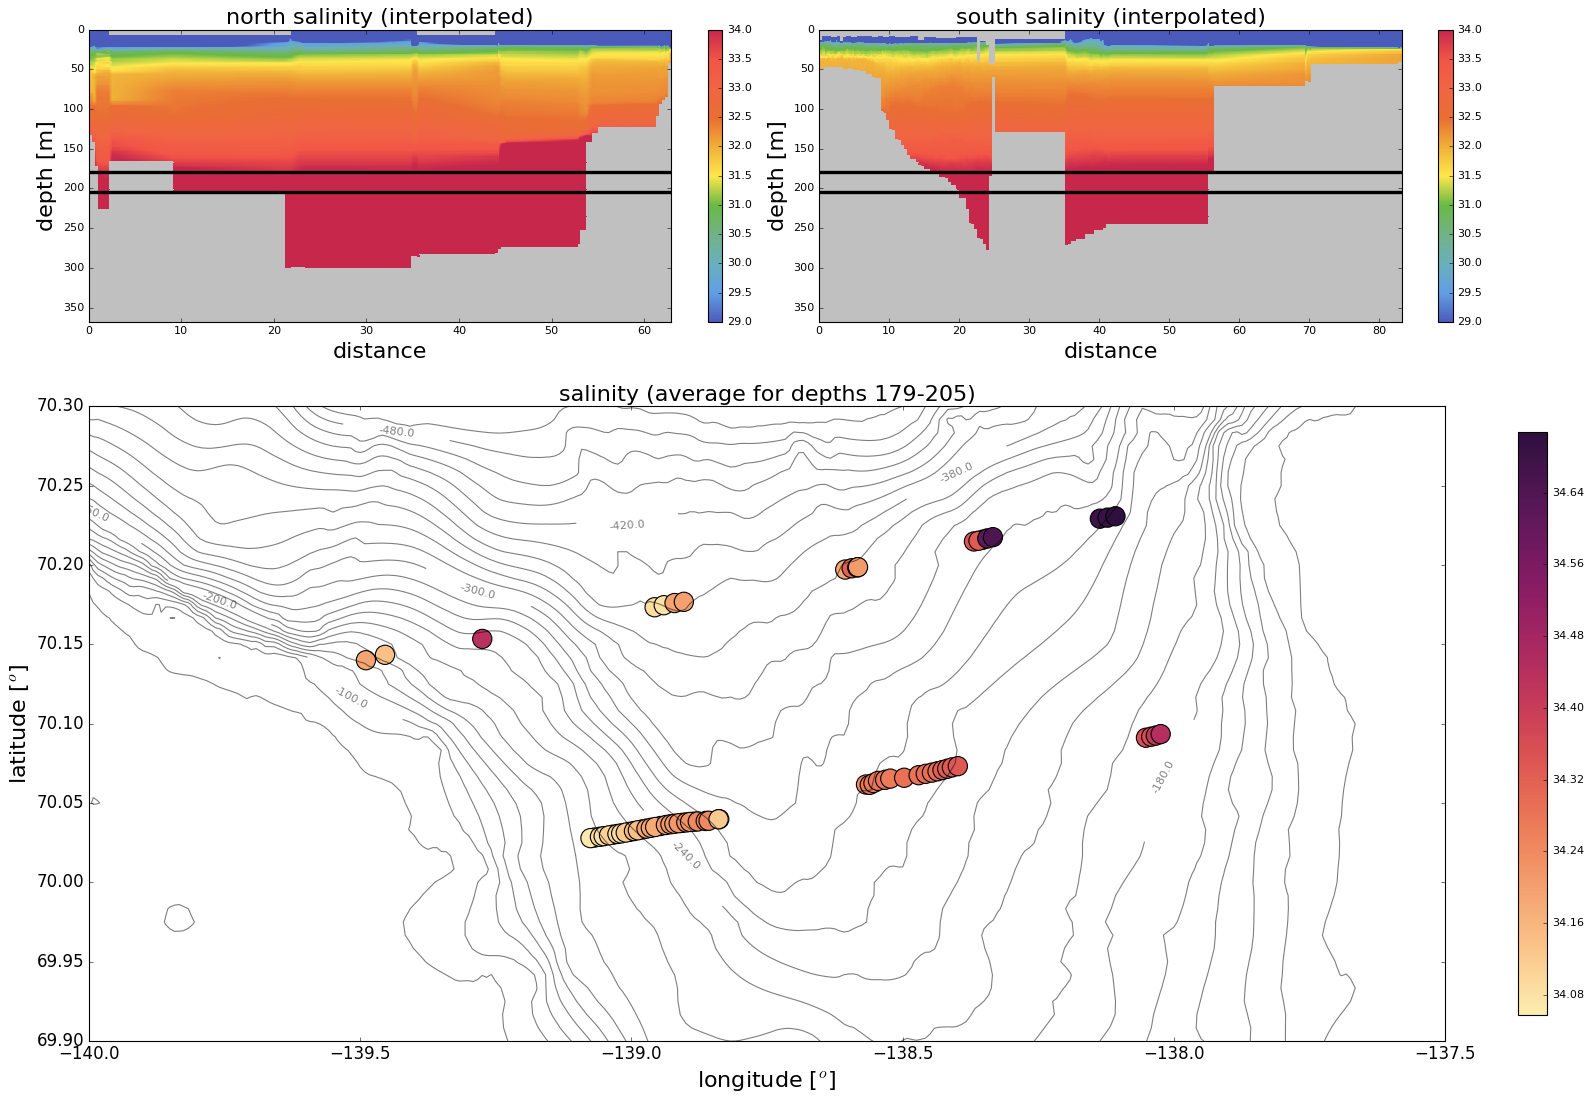

In [28]:
fig = scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n, 
                  temp_s, temp_n, salt_s, salt_n, 179, 205, 'salinity')

### 6. Bottom

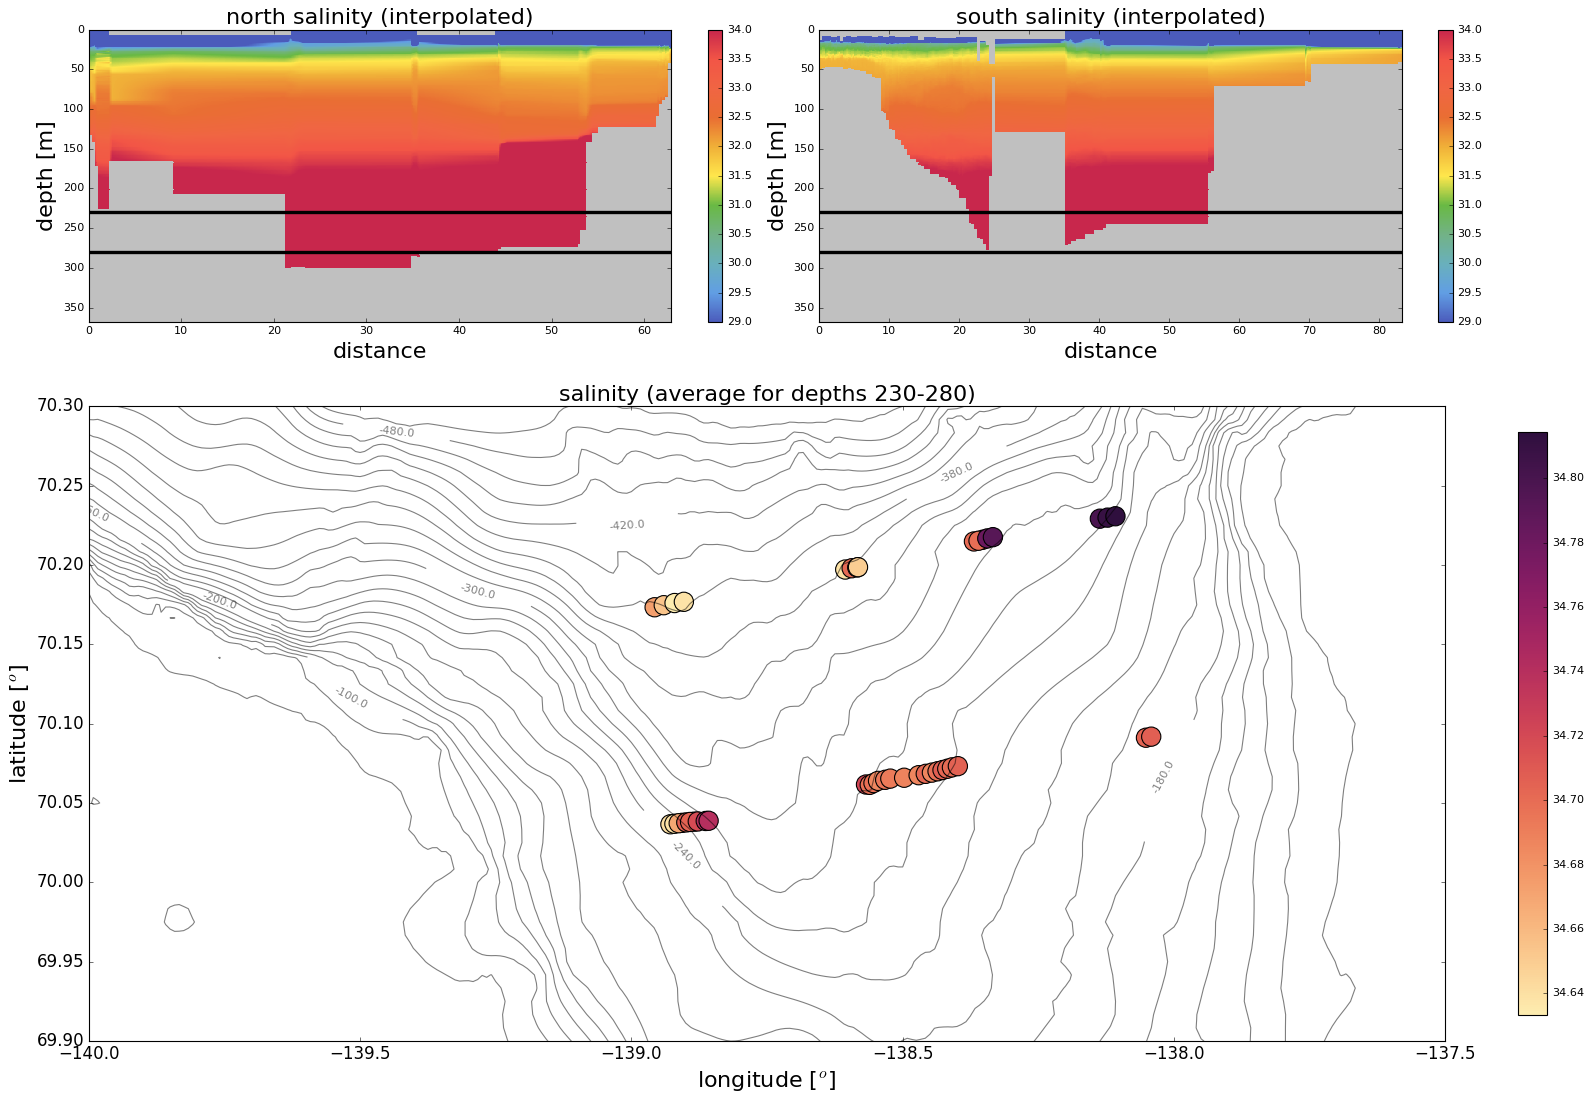

In [29]:
fig = scatter_map(x, y, z, lon_s, lon_n, lat_s, lat_n, dist_n, dist_s, dep_s, dep_n, 
                  temp_s, temp_n, salt_s, salt_n, 230, 280, 'salinity')